The measurement of the muon transverse momentum of muons is sensitive to several detector conditions:
   * the *alignment* of the tracker and of the muon chambers
   * the *composition and distribution of the material* inside the tracking volume
   * the knowledge of the *magnetic field* inside and outside the solenoid volume.
<br>

All these conditions affect differently the momentum measurement and can produce biases. In particular, the detector misalignment produces a relative bias that generally increases linearly with the momentum. For this reason it is extremely important to have an accurate knowledge of the tracker and muon spectrometer alignment, and a detailed mapping of the detector material and of the magnetic field. Residual biases can be corrected *a posteriori*, using calibration techniques that generally exploit data from very well-known processes, such as J/&psi;&rarr;&mu;&mu; or Z&rarr;&mu;&mu; decays.

In [5]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT

In [6]:
#events=uproot.open('/eos/purdue/store/mc/Run3Summer22NanoAODv13/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/133X_mcRun3_2022_realistic_ForNanov13_v1-v1/50000/1c16ff7d-a4ad-44cd-80fd-42840958ce79.root')['Events']
#file=uproot.open('~/Downloads/DYJetsToMuMu_M-50_TuneCP5_13TeV-madgraphMLM-pythia8.root')['Events']
events = NanoEventsFactory.from_root(
    {'/eos/purdue/store/mc/Run3Summer22NanoAODv13/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/133X_mcRun3_2022_realistic_ForNanov13_v1-v1/50000/1c16ff7d-a4ad-44cd-80fd-42840958ce79.root': "Events"}, # We pass a dictionary of {filename1: treename1, filename2: treename2, ...} to load from
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    delayed=False, # You can turn this to True and insert `` commands at the end of variables
).events()

/depot/cms/kernels/hats2024/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [7]:
muon=events.Muon

# Step 1: Generated and reconstructed dimuon Z mass
First, lets reconstruct dimuon z mass.
reapplying previous code. Using the following criteria to select two well-defined and isolated muons. For instance, you can require that both muons pass:<br>

* Muon_genPartIdx!=-1(each muon must have an associated generated particle)
* Muon_isGlobal==1
* Muon_pt>20.
* abs(Muon_eta)<2.4
* Muon_pfRelIso03_chg<0.15

In [8]:
muon_mask=(muon.genPartIdx!=-1)& (muon.isGlobal==1)& (muon.pt>20)& (abs(muon.eta)<2.4)& (muon.pfRelIso03_chg<0.15)

In [9]:
muons_good=muon[muon_mask]

We only keep events with 2 good muons. There are 6 events with over 2 muons, we will ignore them for simplicity.

In [10]:
two_good_muons=muons_good[ak.num(muons_good)==2]

In [11]:
two_good_muons.charge

<Array [[1, -1], [-1, 1], ..., [...], [1, -1]] type='1353 * var * int32[par...'>

Lets make sure muons in eaach events have opposite charge

In [12]:
opposite_sign_muon_mask=(two_good_muons.charge[:,0]!=two_good_muons.charge[:,1])

In [13]:
two_opposite_good_muons=two_good_muons[opposite_sign_muon_mask]

In [13]:
dimuon_p4 = (two_opposite_good_muons[:, 0] + two_opposite_good_muons[:, 1])

In [14]:
print(dimuon_p4.mass)

[92, 84.5, 94.3, 92.5, 93.2, 56.2, 87.4, ..., 94, 90.4, 88.3, 87.1, 86.5, 98.9]


We can further restrict the selection by requiring the invariant mass is between 70 and 110 GeV

In [17]:
dimuon_mass_mask=((dimuon_p4.mass>70)&(dimuon_p4.mass<110))

Text(0, 0.5, 'Events')

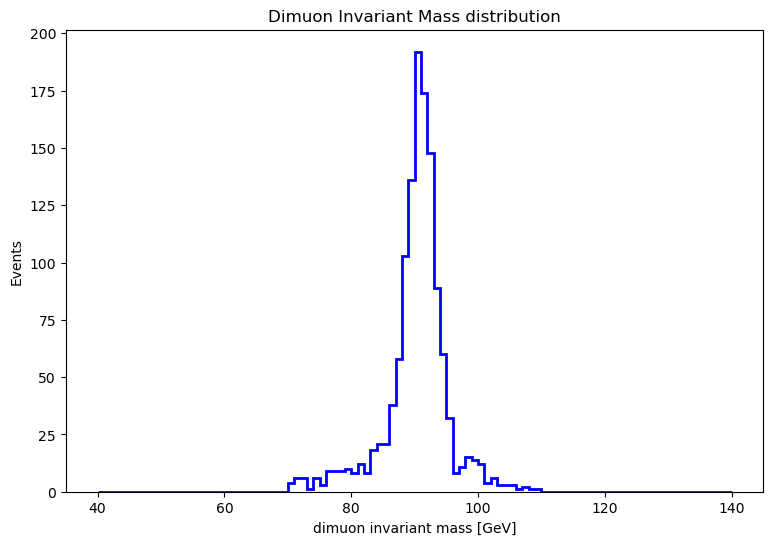

In [18]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [19]:
gen_muon=two_opposite_good_muons.matched_gen

In [20]:
gen_dimuon_p4=gen_muon[:,0]+gen_muon[:,1]
print(gen_dimuon_p4.mass)

[90.8, 87.3, 92.9, 92.1, 94.3, 55.7, ..., 92.3, 90.1, 86.8, 87.8, 85.5, 99.6]


Text(0, 0.5, 'Events')

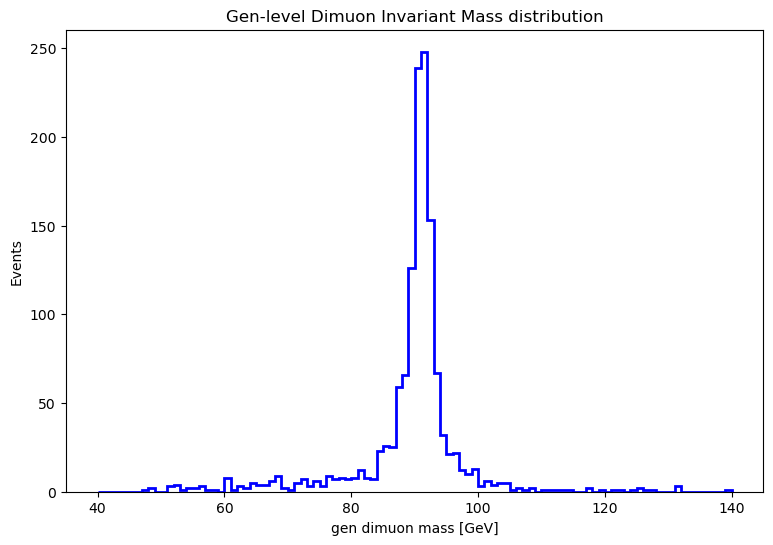

In [21]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

Then, we fit both generated and reconstructed Z mass.<br>
Keep in mind that the Z line shape is not Gaussian, so the Gaussian fit might not be perfect. We then fit them with more suitable functions for each case, e.g. a Breit-Wigner function for the generated mass and a Voigt function (i.e. a convolution of a Breit-Wigner with a Gaussian) for the reconstructed mass. You can easily do this from the ROOT e.g.:

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      23.5273
NDf                       =           17
Edm                       =  4.95447e-07
NCalls                    =           84
p0                        =      612.019   +/-   20.203      
p1                        =      91.0208   +/-   0.0580336   
p2                        =      2.78605   +/-   0.141504    


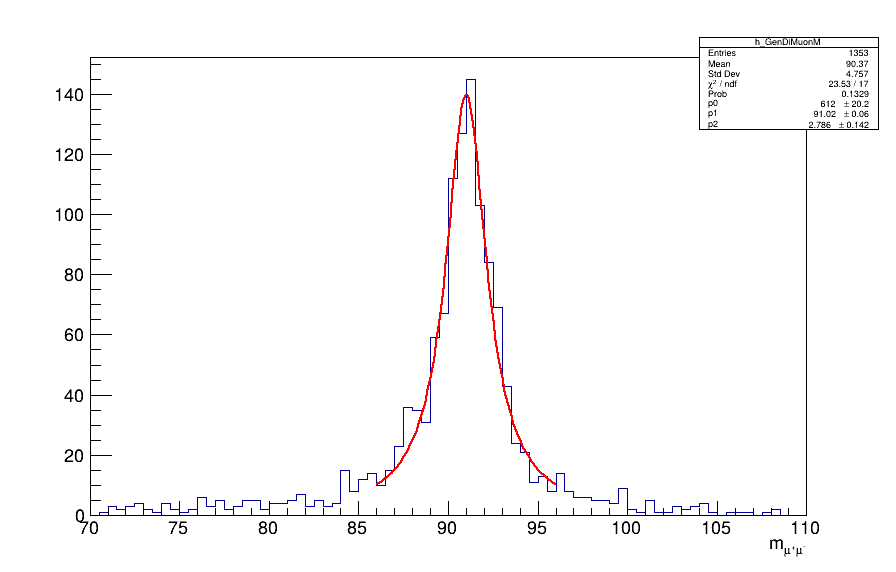

In [22]:
c1 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c1.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c1.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      15.5076
NDf                       =           16
Edm                       =  1.76883e-07
NCalls                    =          133
p0                        =      625.477   +/-   23.3215     
p1                        =      90.9318   +/-   0.0869541   
p2                        =      1.37472   +/-   3.36133e-05 
p3                        =       2.8167   +/-   0.261617    


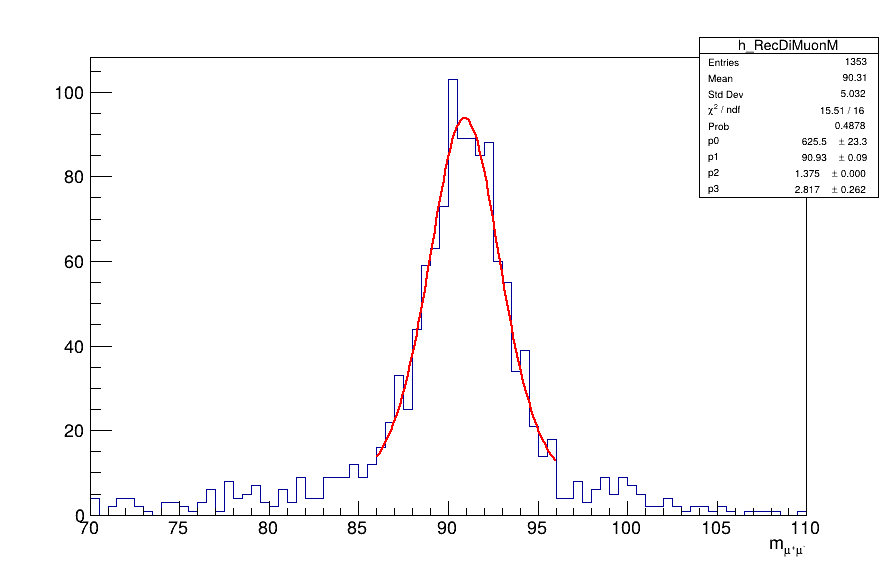

In [23]:
c2 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c2.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c2.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

**Questions 1:**
   * Compare the mean values obtained from the fits to the generated and reconstructed distributions. Are they compatible or do they differ significantly? How do they compare to the nominal Z mass value, m<sub>Z</sub> = 91.1876 GeV? Which distribution has the larger shift with respect to m<sub>Z</sub>?
   * Compare the widths of the two distributions (GEN and RECO). Which one is larger? Can you explain why? 
   * Considering that the natural width of the Z boson is &Gamma;<sub>Z</sub> = 2.4952 GeV, can you roughly estimate the typical dimuon mass resolution of Z&rarr;&mu;&mu; events measured with the CMS detector?(*Note:* with a _Voigtian_ fit, you would get an estimate of the  mass resolution directly from the fit) 
   * Why do you need different functions to better fit the generated and reconstructed mass distributions? What differs between the two? If you had to fit the peak of a reconstructed J/&psi; instead, what function would you use, and why?



# Step 2: Investigate the shape of the dimuon mass spectrum
Next, we will create [TProfile histograms](http://root.cern.ch/root/html/TProfile.html) of the reconstructed dimuon invariant mass _vs_ azimuthal coordinate of the muon direction (&phi;), separately for positive and negative muons, as well as the dimuon mass _vs_ pseudorapidity (&eta;) of the muon. E.g.:

In [24]:
prof_MuPlusPhiVsDiMuonM=ROOT.TProfile("prof_MuPlusPhivsDiMuonM","#mu^{+} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(+) #phi[rad]; Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

In [25]:
mup_phi=ak.flatten(two_opposite_good_muons.phi[two_opposite_good_muons.charge>0])

In [26]:
for phi, m in zip(mup_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuPlusPhiVsDiMuonM.Fill(phi, m, 1)

In [27]:
c3 = ROOT.TCanvas("mupphidimum","",900,600)
prof_MuPlusPhiVsDiMuonM.Draw()

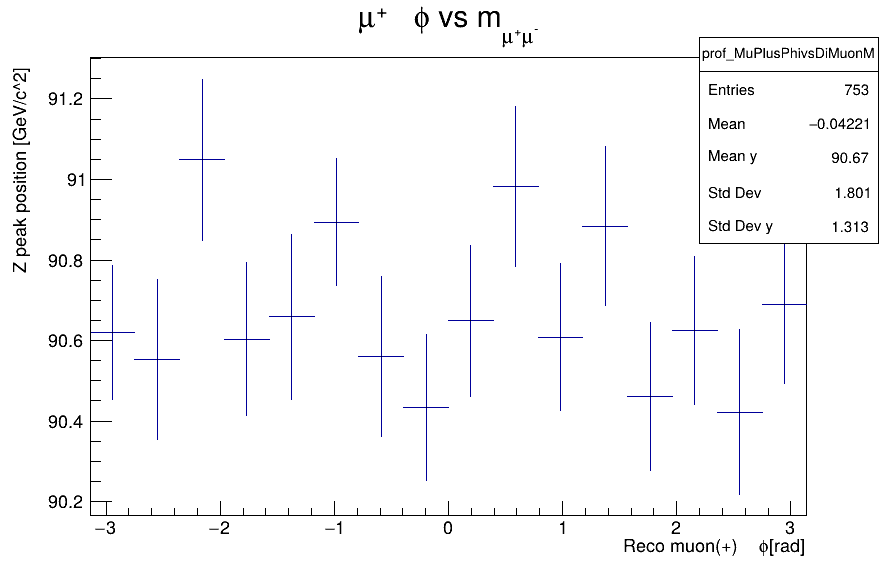

In [28]:
c3.Draw()

In [29]:
mum_phi=ak.flatten(two_opposite_good_muons.phi[two_opposite_good_muons.charge<0])
prof_MuMinusPhivsDiMuonM = ROOT.TProfile("prof_MuMinusPhivsDiMuonM","#mu^{-} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(-) #phi[rad];Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

In [30]:
for phi, m in zip(mum_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuMinusPhivsDiMuonM.Fill(phi, m, 1)

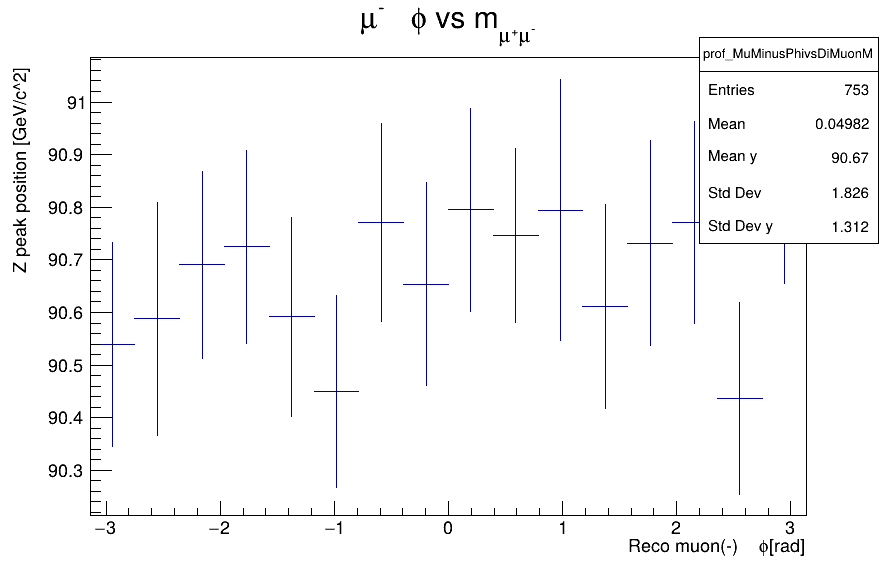

In [31]:
c4 = ROOT.TCanvas("mumphidimum","",900,600)
prof_MuMinusPhivsDiMuonM.Draw()
c4.Draw()

In [32]:
prof_MuEtavsDiMuonM = ROOT.TProfile("prof_MuEtavsDiMuonM","Muon #eta vs m_{#mu^{+}#mu^{-}};Reco Muon #eta; Z peak position [GeV/c^2]",50,-2.4,2.4,88,93)

In [33]:
for eta1, eta2, m in zip(two_opposite_good_muons[dimuon_mass_mask].eta[:,0],
                         two_opposite_good_muons[dimuon_mass_mask].eta[:,0],
                         dimuon_p4.mass[dimuon_mass_mask]):
    prof_MuEtavsDiMuonM.Fill(eta1, m, 1)
    prof_MuEtavsDiMuonM.Fill(eta2, m, 1)
    

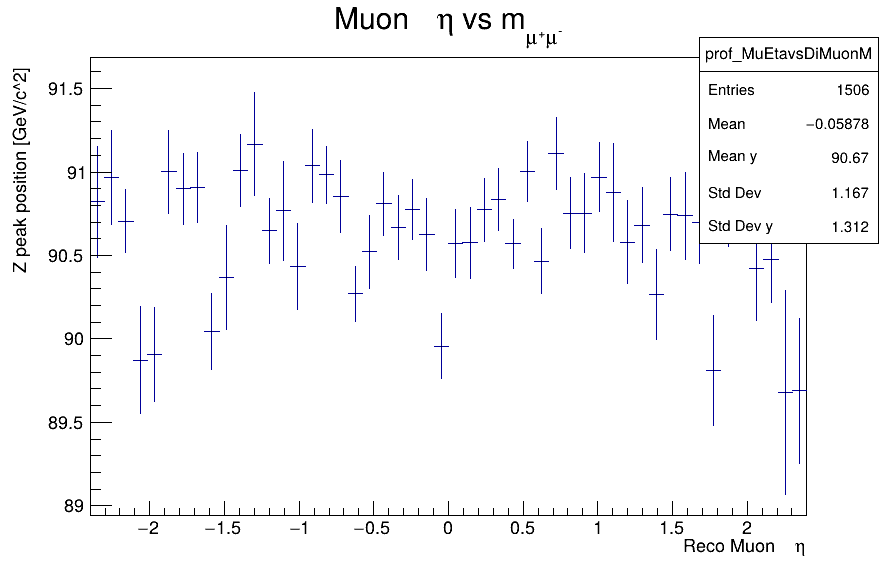

In [34]:
c5 = ROOT.TCanvas("muetadimum","",900,600)
prof_MuEtavsDiMuonM.Draw()
c5.Draw()

**Questions 2:**
   * What do they look like? Is the reconstructed mass flat _vs_ &phi; and &eta; or are there deviations? 
   * Are the deviations compatible with statistical fluctuations or do you notice a trend? 
   * What could explain this behavior?


# Step 3: Investigate the muon transverse momentum resolution

Now we will study the muon transverse momentum resolution. We will consider distributions of the transverse momentum residuals, defined as  R(1/pT) = (1/pT<sup>REC</sup> &ndash; 1/pT<sup>GEN</sup>)/(1/pT<sup>GEN</sup>). In the ideal case, the distribution of the residuals is expected to be Gaussian and its standard deviation is the pT resolution. Likewise, we can define the dimuon invariant mass residuals as R(M) = (M<sup>REC</sup> &ndash; M<sup>GEN</sup>)/M<sup>GEN</sup>, and the standard deviation of the R(M) distribution defines the mass resolution. 

We will create the following histograms:
   * 1D histogram of the muon transverse momentum residuals R(1/PT): A histogram (h_MupTRes) of the muon transverse momentum residual using the PAT muons and GEN muons. Fit this distribution to a Gaussian function. The fit parameter sigma gives the muon transverse momentum resolution in the chosen p<sub>T</sub> range.
   * 1D histogram of the dimuon invariant mass residuals R(M): A histogram (h_MassRes) for the invariant mass resolution residual, which is defined as (M<sub>rec</sub> - M<sub>gen</sub> )/M<sub>gen</sub>. Fit this distribution to a Gaussian.
   * Profile histograms (prof_MupTvspTRes and prof_MuEtavspTRes) of muon transverse momentum residuals  as a function of muon pT and &eta;.
Note that, by default, a [TProfile](http://root.cern.ch/root/html/TProfile.html) will display in each bin the <span style='color:red'> mean value $\pm$ mean value error </span> (i.e. RMS/$\sqrt(N)$). Initializing the [TProfile](http://root.cern.ch/root/html/TProfile.html)  with option "s" instead, it will display <span style='color:red'> mean value $\pm$ RMS </span>. This is more useful for us, as the RMS estimates the standard deviation, i.e. the resolution of each bin. 

Text(0, 0.5, 'Events')

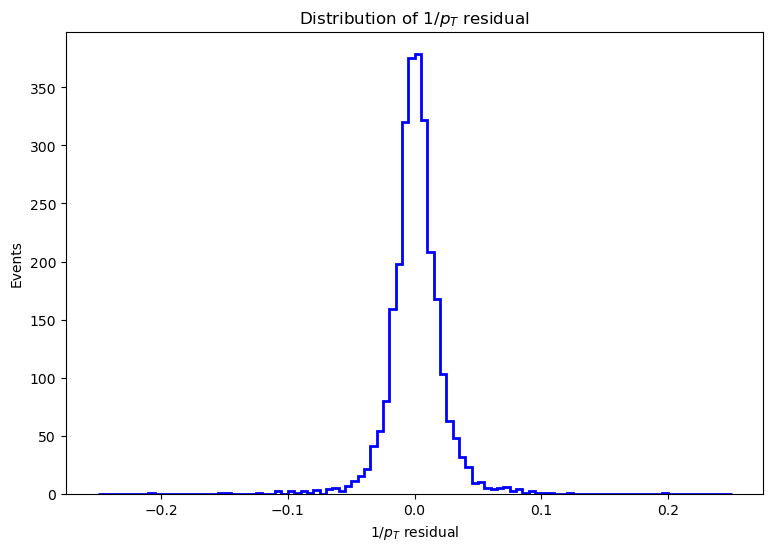

In [35]:
pt_res=ak.flatten(two_opposite_good_muons.matched_gen.pt)/ak.flatten(two_opposite_good_muons.pt)-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [36]:
mass_res=dimuon_p4.mass/gen_dimuon_p4.mass-1

Text(0, 0.5, 'Events')

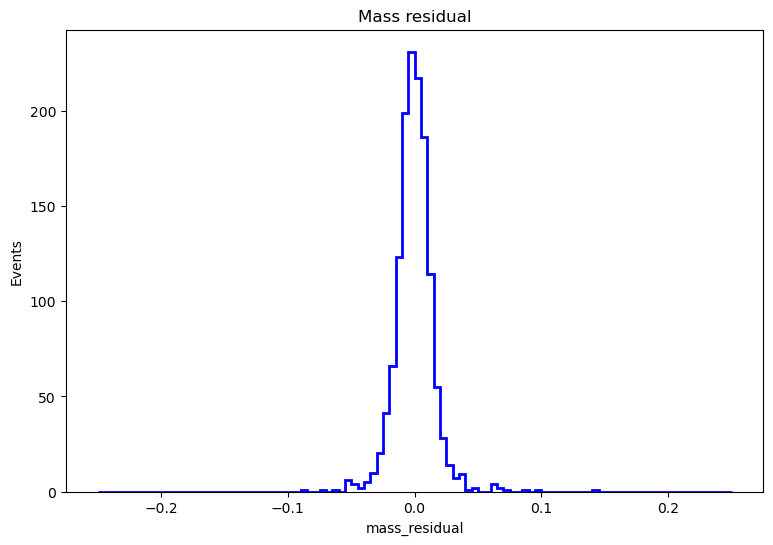

In [37]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      151.879
NDf                       =           44
Edm                       =  1.56173e-09
NCalls                    =           69
Constant                  =      327.996   +/-   9.38354     
Mean                      =  0.000756398   +/-   0.000308442 
Sigma                     =    0.0155268   +/-   0.000320673  	 (limited)


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

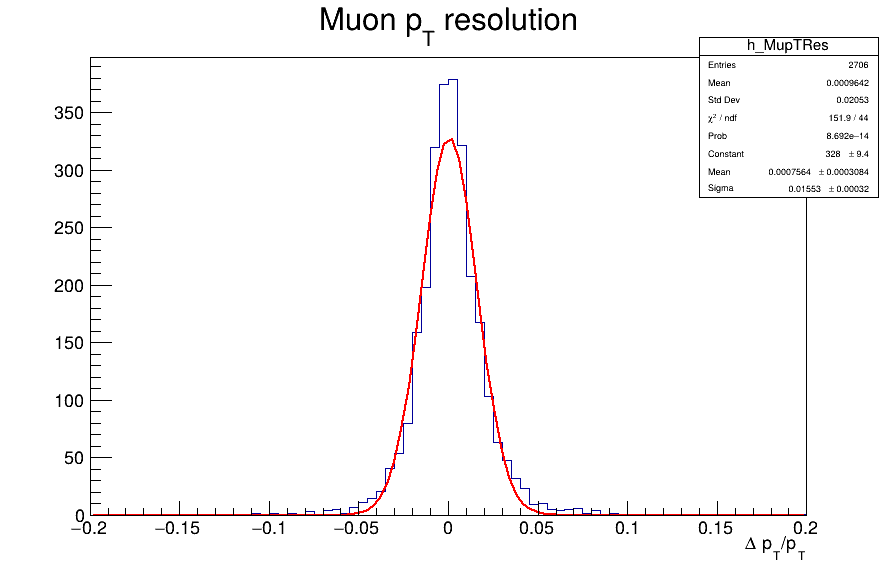

In [38]:
c6 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c6.Draw()
h_MupTRes.Fit("gaus")

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      60.3285
NDf                       =           34
Edm                       =  9.66841e-09
NCalls                    =           72
Constant                  =      166.548   +/-   6.29656     
Mean                      = -0.000650271   +/-   0.000324527 
Sigma                     =    0.0116117   +/-   0.000297317  	 (limited)


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

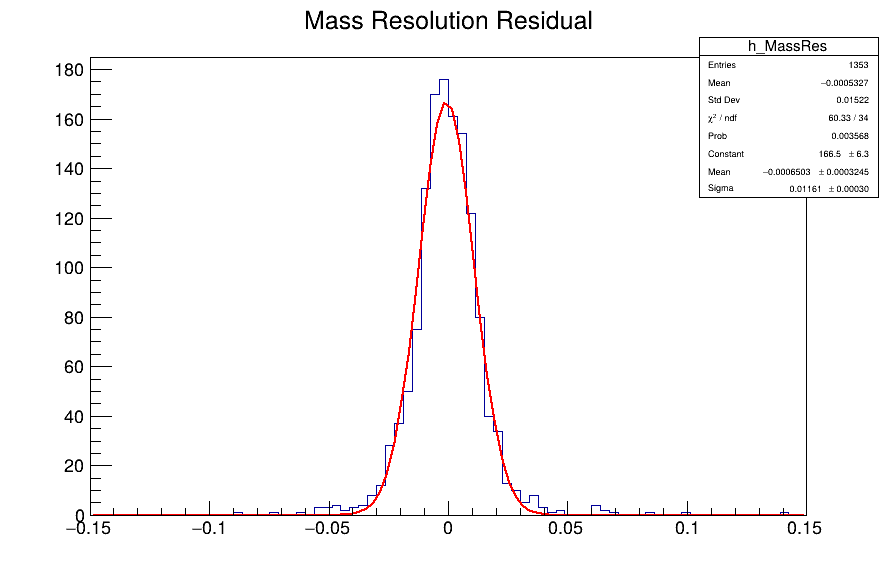

In [39]:
c7 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c7.Draw()
h_MassRes.Fit("gaus")

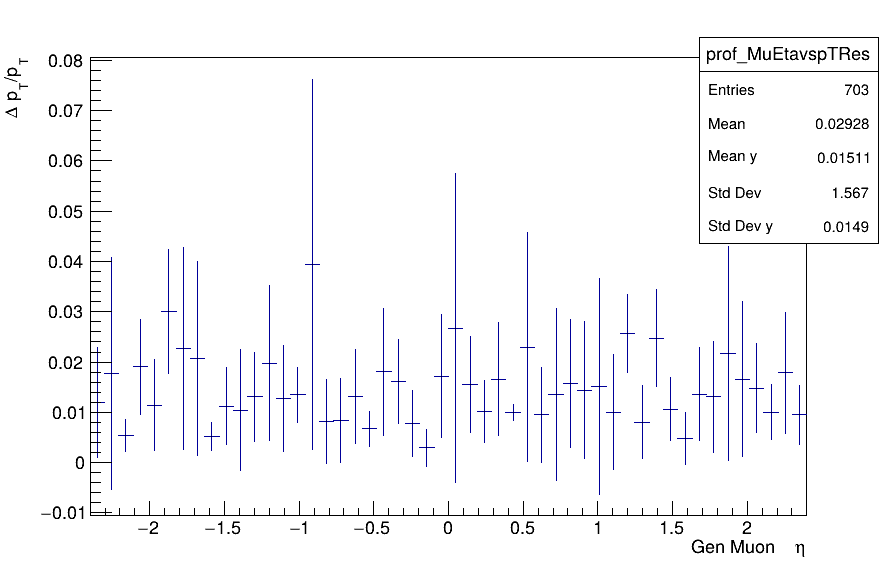

In [40]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, gen_dimuon_p4.eta):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c8 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c8.Draw()

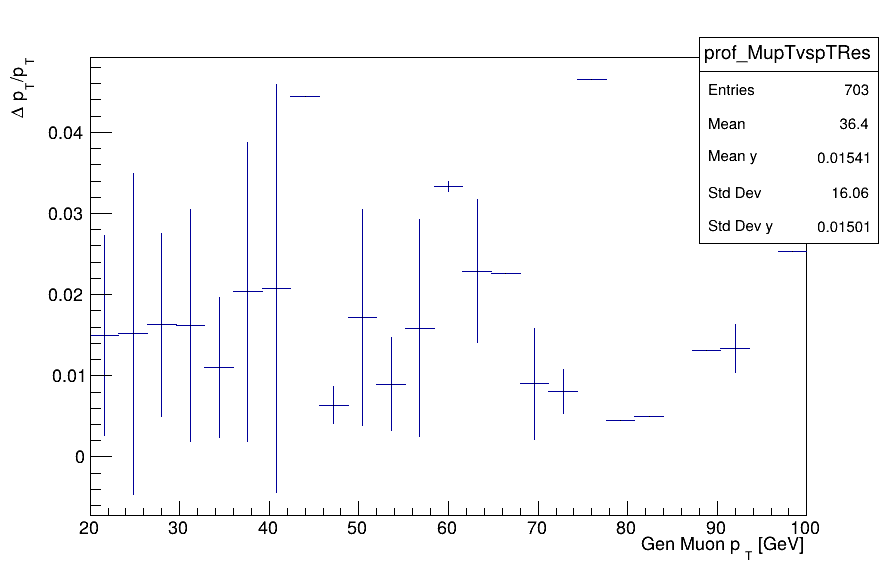

In [41]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1,'s')
for ptres, pt in zip(pt_res, gen_dimuon_p4.pt):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c9 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c9.Draw()

**Questions 3**:
* What is the typical 1/pT resolution of a 50 GeV muon measured in the CMS detector?
* How does the 1/pT resolution scale with transverse momentum? And with the pseudorapidity?
* Why is the mass residual not a perfect Gaussian distribution?
* How is the 1/pT resolution related to the invariant mass resolution?

# Step 4: Momentum scale corrections

As mentioned in the introduction, small biases in the muon momentum measurement can be recovered by applying specific corrections. In CMS we have several algorithms to compute such corrections to the momentum scale and/or resolution. They are documented in this MUO POG [TWiki page](https://twiki.cern.ch/twiki/bin/view/CMS/MuonReferenceScaleResolRun2). In the following, we will demonstrate the use of one of these correction strategies, called _Rochester algorithm_. The details of the algorithm and how it computes the corrections are beyond the goals of this exercise. Suffice it to say that it extracts correction factors by "forcing" muons from (mostly) Z&rarr;&mu;&mu; decays to coincide with reference distributions obtained from Monte Carlo generated muons. For more details, check out  [EPJC V72, 10.2194 (2012)](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-012-2194-8) [arXiv:1208.3710](https://arxiv.org/abs/1208.3710) or the link above.


We are going to need both ROOT and the correctionlib package to read and apply the corrections. 

In [2]:
import ROOT
import correctionlib

The code to apply the correction is written in C++, so we are using pyROOTs ability to run this kind of code. 

In [3]:
correctionlib.register_pyroot_binding()

ROOT.EnableImplicitMT()

ROOT.gROOT.ProcessLine(
    'auto cset = correction::CorrectionSet::from_file("2022_schemaV2.json");'
)
ROOT.gROOT.ProcessLine('#include "MuonScaRe.cc"')


0

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 4 threads accordingly


In [14]:
random=np.random.rand(len(ak.flatten(muon.eta)))

In [15]:
two_opposite_good_muons.pt

<Array [[46.8, 44.1], [...], ..., [48.6, 47.4]] type='1353 * var * float32[...'>

In [16]:
rnd=ROOT.TRandom3(1234)

Now, write a loop to correct each muon one by one, and then repeat step 2 and 3

In [17]:
scaled_two_opposite_good_muons = two_opposite_good_muons 
scaled_two_opposite_good_muons.pt = pt_scale(1, scaled_two_opposite_good_muons.pt, scaled_two_opposite_good_muons.eta, scaled_two_opposite_good_muons.phi, scaled_two_opposite_good_muons.charge, "nom")      

NameError: name 'pt_scale' is not defined

In [ ]:
scaled_two_opposite_good_muons=ak.JaggedArray.zip(muon_pt= ak.fromiter(cor_pt), 
                                                  muon_eta= ak.fromiter(cor_eta),
                                                  muon_phi= ak.fromiter(cor_phi),
                                                  muon_mass= two_opposite_good_muons.muon_mass,
                                                  muon_charge= two_opposite_good_muons.muon_charge,
                                                  genpart_pt= two_opposite_good_muons.genpart_pt,
                                                  genpart_eta= two_opposite_good_muons.genpart_eta,
                                                  genpart_phi= two_opposite_good_muons.genpart_phi,
                                                  genpart_mass= two_opposite_good_muons.genpart_mass,)

In [ ]:
uncorrected_two_opposite_good_muons= two_opposite_good_muons
two_opposite_good_muons=scaled_two_opposite_good_muons

In [ ]:
two_muon_p4=uproot_methods.TLorentzVectorArray.from_ptetaphim(two_opposite_good_muons.muon_pt, two_opposite_good_muons.muon_eta,
                                                              two_opposite_good_muons.muon_phi, two_opposite_good_muons.muon_mass)

In [ ]:
dimuon_p4=two_muon_p4[:,0]+two_muon_p4[:,1]
#dimuon_p4.mass

In [ ]:
dimuon_mass_mask=(dimuon_p4.mass>70)&(dimuon_p4.mass<110)

In [ ]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [ ]:
two_gen_muon_p4=uproot_methods.TLorentzVectorArray.from_ptetaphim(two_opposite_good_muons.genpart_pt, two_opposite_good_muons.genpart_eta,
                                                                  two_opposite_good_muons.genpart_phi, two_opposite_good_muons.genpart_mass)

In [ ]:
gen_dimuon_p4=two_gen_muon_p4[:,0]+two_gen_muon_p4[:,1]

In [ ]:
gen_dimuon_p4.mass

In [ ]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

In [ ]:
c10 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c10.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c10.Draw()

In [ ]:
c11 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c11.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c11.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

In [ ]:
prof_MuPlusPhiVsDiMuonM=ROOT.TProfile("prof_MuPlusPhivsDiMuonM","#mu^{+} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(+) #phi[rad]; Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

In [ ]:
mup_phi=two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge>0].flatten()

In [ ]:
for phi, m in zip(mup_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuPlusPhiVsDiMuonM.Fill(phi, m, 1)

In [ ]:
c12 = ROOT.TCanvas("mupphidimum","",900,600)
prof_MuPlusPhiVsDiMuonM.Draw()

In [ ]:
c12.Draw()

In [ ]:
mum_phi=two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge<0].flatten()
prof_MuMinusPhivsDiMuonM = ROOT.TProfile("prof_MuMinusPhivsDiMuonM","#mu^{-} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(-) #phi[rad];Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

In [ ]:
for phi, m in zip(mum_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuMinusPhivsDiMuonM.Fill(phi, m, 1)

In [ ]:
c13 = ROOT.TCanvas("mumphidimum","",900,600)
prof_MuMinusPhivsDiMuonM.Draw()
c13.Draw()

In [ ]:
prof_MuEtavsDiMuonM = ROOT.TProfile("prof_MuEtavsDiMuonM","Muon #eta vs m_{#mu^{+}#mu^{-}};Reco Muon #eta; Z peak position [GeV/c^2]",50,-2.4,2.4,88,93)

In [ ]:
for eta1, eta2, m in zip(two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         dimuon_p4.mass[dimuon_mass_mask]):
    prof_MuEtavsDiMuonM.Fill(eta1, m, 1)
    prof_MuEtavsDiMuonM.Fill(eta2, m, 1)
    

In [ ]:
c14 = ROOT.TCanvas("muetadimum","",900,600)
prof_MuEtavsDiMuonM.Draw()
c14.Draw()

In [ ]:
pt_res=two_opposite_good_muons.genpart_pt.flatten()/two_opposite_good_muons.muon_pt.flatten()-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [ ]:
mass_res=dimuon_p4.mass.flatten()/gen_dimuon_p4.mass.flatten()-1

In [ ]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

In [ ]:
c16 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c16.Draw()
h_MupTRes.Fit("gaus")

In [ ]:
c17 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c17.Draw()
h_MassRes.Fit("gaus")

In [ ]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1,'s')
for ptres, eta in zip(pt_res, two_gen_muon_p4.eta.flatten()):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c18 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c18.Draw()

In [ ]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1,'s')
for ptres, pt in zip(pt_res, two_gen_muon_p4.pt.flatten()):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c19 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c19.Draw()

**Questions 4:**
   * Describe the main differences that you observe between the uncorrected and corrected distributions. 
   * Does the corrected mass spectrum get closer to the generated mass spectrum, and the peak closer to the PDG value? 
   * Do the corrections help restore a flat distribution of the dimuon mass _vs_ &phi; and &eta;? 
   * How did the resolution change after the corrections? How would you explain it? 